# Libraries

In [2]:
import matplotlib.pyplot as plt
import matplotlib.axes as axes
%matplotlib inline
import numpy as np
import networkx as nx
from qiskit import BasicAer
from qiskit.tools.visualization import plot_histogram
from qiskit.aqua import run_algorithm
from qiskit.aqua.input import EnergyInput
from qiskit.aqua.translators.ising import max_cut, tsp
from qiskit.aqua.algorithms import VQE, ExactEigensolver, QAOA
from qiskit.aqua.components.optimizers import SPSA
from qiskit.aqua.components.variational_forms import RY
from qiskit.aqua import QuantumInstance
from docplex.mp.model import Model
from qiskit.aqua.translators.ising import docplex
from pyqubo import Binary, solve_ising,Constraint
import numpy as np
# setup aqua logging
import logging
from qiskit.aqua import set_qiskit_aqua_logging
import time
import matplotlib.pyplot as plt

# Function to take input and return the qubo

In [3]:
def quboformation():
    # # Define hamiltonian
    k=int(input("enter required sum : "))
    n=int(input("enter # of elements in set : "))
    a=np.zeros((n))
    q=0
    s={i:'s%d' %i for i in range (n)}
    z={i:'s%d' %i for i in range (n)}
    for i in range(0,n):
        a[i]=int(input("element " + str(i+1)+ " : "))
        s[i]=Binary("s{}".format(i))
    for i in range(0,n):
        q=q+s[i]*a[i]
    H=(k-q)**2

    # Create Ising model
    model = H.compile()
    linear, quad,offset = model.to_ising()

    # Solve Ising model
    solution = solve_ising(linear, quad)
    solution 

    model = H.compile()

    qubo, offset = model.to_qubo()
    i=0
    j=1
    z=-1
    arr = np.zeros((n,n))
    for x in qubo:
        if(j<n and z==-1):
            arr[i][j] = qubo[x]
            j=j+1
        elif (i<n-2 and z==-1):
            i = i+1
            j=i+1
            arr[i][j] = qubo[x]
            j=j+1
        else:
            z=z+1
            arr[z][z] = qubo[x]        
    return arr,offset,n,k,a,qubo


# Qubo Formation

In [4]:
# Create an instance of a model and variables.
mdl = Model(name='max_cut')
arr,offset,n,k,a,qubo = quboformation()
s={i:'s%d' %i for i in range (n)}
for i in range(n):
    s[i]=mdl.binary_var("s{}".format(i))
subset_sum_func=offset
for i in range(n):
    for j in range(n):
        subset_sum_func=subset_sum_func+s[i]*s[j]*arr[i][j]
mdl.minimize(subset_sum_func) 
qubitOp, offset = docplex.get_qubitops(mdl)  
qubitOp

enter required sum : 4
enter # of elements in set : 3
element 1 : 2
element 2 : 2
element 3 : 4


# VQE Method

In [5]:
ee = ExactEigensolver(qubitOp, k=70)
result = ee.run()

"""
algorithm_cfg = {
    'name': 'ExactEigensolver',
}

params = {
    'problem': {'name': 'ising'},
    'algorithm': algorithm_cfg
}
result = run_algorithm(params,algo_input)
"""
print(2^n)
for i in range(0,(2**n)):
    x = max_cut.sample_most_likely(result['eigvecs'][i])
    obj=0
    for i in range(n):
        obj=obj+ a[i]*x[i]
    obj=(k-obj)**2
    print('Objective',result['energy'])
    print('solution',max_cut.get_graph_solution(x))
    print('energy:', result['energy'])
    print('obj sol',obj)
    print('\n')

1
Objective -6.0
solution [0. 0. 1.]
energy: -6.0
obj sol 0.0


Objective -6.0
solution [1. 1. 0.]
energy: -6.0
obj sol 0.0


Objective -6.0
solution [0. 1. 1.]
energy: -6.0
obj sol 4.0


Objective -6.0
solution [1. 0. 1.]
energy: -6.0
obj sol 4.0


Objective -6.0
solution [0. 1. 0.]
energy: -6.0
obj sol 4.0


Objective -6.0
solution [1. 0. 0.]
energy: -6.0
obj sol 4.0


Objective -6.0
solution [1. 1. 1.]
energy: -6.0
obj sol 16.0


Objective -6.0
solution [0. 0. 0.]
energy: -6.0
obj sol 16.0




# Choosing the Best Solution

In [6]:
var = 10
arr1 = []
arr2 =[]
for i in range(var):
    seed = 10598

    spsa = SPSA(max_trials=300)
    ry = RY(qubitOp.num_qubits, depth=i, entanglement='linear')
    vqe = VQE(qubitOp, ry, spsa)

    backend = BasicAer.get_backend('statevector_simulator')
    quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)

    result = vqe.run(quantum_instance)

    """declarative approach
    algorithm_cfg = {
        'name': 'VQE'
    }

    optimizer_cfg = {
        'name': 'SPSA',
        'max_trials': 300
    }

    var_form_cfg = {
        'name': 'RY',
        'depth': 5,
        'entanglement': 'linear'
    }

    params = {
        'problem': {'name': 'ising', 'random_seed': seed},
        'algorithm': algorithm_cfg,
        'optimizer': optimizer_cfg,
        'variational_form': var_form_cfg,
        'backend': {provider': 'qiskit.BasicAer', 'name': 'statevector_simulator'}
    }

    result = run_algorithm(params, algo_input)
    """

    x = max_cut.sample_most_likely(result['eigvecs'][0])
    obj=0
    for i in range(n):
        obj=obj+ a[i]*x[i]
    obj=(k-obj)**2
    print('energy:', result['energy'])
    print('time:', result['eval_time'])
    print('max-cut objective:', result['energy'] + offset)
    print('solution:', max_cut.get_graph_solution(x))
    print('solution objective: ', obj)
    arr1.append(result['eval_time'])
    arr2.append(result['energy'] + offset)

energy: -5.999790740777095
time: 4.892743825912476
max-cut objective: 0.000209259222905267
solution: [1. 1. 0.]
solution objective:  0.0
energy: -5.998776359040835
time: 11.10805606842041
max-cut objective: 0.001223640959165273
solution: [0. 0. 1.]
solution objective:  0.0
energy: -5.999144863353973
time: 15.57807207107544
max-cut objective: 0.0008551366460274323
solution: [0. 0. 1.]
solution objective:  0.0
energy: -5.999975514395936
time: 21.289767265319824
max-cut objective: 2.44856040643171e-05
solution: [1. 1. 0.]
solution objective:  0.0
energy: -5.999980109583227
time: 27.283381938934326
max-cut objective: 1.989041677319392e-05
solution: [1. 1. 0.]
solution objective:  0.0
energy: -5.999778867303144
time: 32.50537085533142
max-cut objective: 0.0002211326968559746
solution: [0. 0. 1.]
solution objective:  0.0
energy: -5.999716487805751
time: 38.394126892089844
max-cut objective: 0.0002835121942492691
solution: [0. 0. 1.]
solution objective:  0.0
energy: -5.999822073756512
time: 4

# Plotting Graphs

Text(0, 0.5, 'SubSet-Sum Objective')

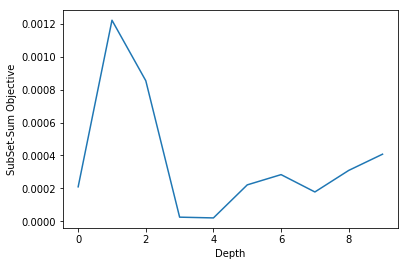

In [7]:
plt.plot(arr2)
plt.xlabel("Depth")
plt.ylabel("SubSet-Sum Objective")

# Drawing Circuit

In [8]:
cct = vqe.construct_circuit(result['opt_params'], statevector_mode=True)[0]
cct.draw()

# DWAVE

In [9]:
from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite
sampler = DWaveSampler(endpoint='https://cloud.dwavesys.com/sapi', solver='DW_2000Q_2_1')
sampler_embedded = EmbeddingComposite(sampler)

Q = qubo
total_occur = []
time_sec = []

for c in range(10):
    total_occur.append(0)
    t1 = time.time()
    response = sampler_embedded.sample_qubo(Q, num_reads=5000,chain_strength=c)
    time_sec.append(time.time()-t1)
    x=[]
    ene = []
    occ=[]
    for datum in response.data(['sample', 'energy', 'num_occurrences']):   
        x.append(datum.sample)
        ene.append(datum.energy)
        occ.append(datum.num_occurrences)
    z={i:'s%d' %i for i in range (n)}
    sum =[]
    for i in range(len(x)):
        sum.append(0)
        for j in range(n):
            if(x[i][z[j]]==1):
                sum[i]+= a[j]
        if(sum[i]==k):
            total_occur[c]+=occ[i]

# Plotting Graphs

Text(0, 0.5, 'Number of Occurances')

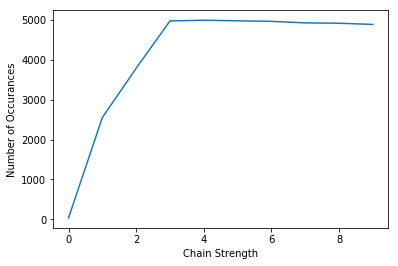

In [10]:
plt.plot(total_occur)
plt.xlabel("Chain Strength")
plt.ylabel("Number of Occurances")

Text(0, 0.5, 'Processing Time')

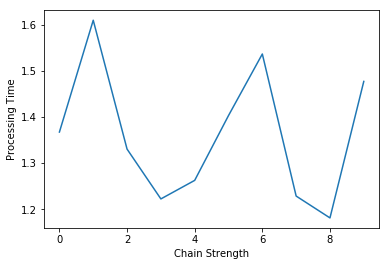

In [11]:
plt.plot(time_sec)
plt.xlabel("Chain Strength")
plt.ylabel("Processing Time")